# SageMaker Builtin - K-Means - Example

Original example:

https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/US-census_population_segmentation_PCA_Kmeans/sagemaker-countycensusclustering.ipynb

### Analyze US census data for population segmentation using Amazon SageMaker¶


This is modified to run from a local SageMaker instance.


## Step 1: Load the Data

In [1]:
# relevant libraries

import os
import boto3
import io
import sagemaker

%matplotlib inline 

import pandas as pd
import numpy as np

# import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
import pickle, gzip, urllib, json
import csv

In [ ]:
!which python


In [2]:
import mxnet as mx

In [3]:
# execute this on aws sagemaker
from sagemaker import get_execution_role
role = get_execution_role()

In [ ]:
# execute this on local sagemaker
from sagemaker import get_execution_role

# use this if running sagemaker locally
def resolve_sm_role():
    client = boto3.client('iam', region_name='us-east-2')
    response_roles = client.list_roles(
        PathPrefix='/',
        # Marker='string',
        MaxItems=999
    )
    for role in response_roles['Roles']:
        if role['RoleName'].startswith('AmazonSageMaker-ExecutionRole-'):
            print('Resolved SageMaker IAM Role to: ' + str(role))
            return role['Arn']
    raise Exception('Could not resolve what should be the SageMaker role to be used')

# this is the role created by sagemaker notebook on aws
role_arn = resolve_sm_role()
print(role_arn)



In [ ]:
iam = boto3.client('iam')
role = iam.get_role(RoleName='AmazonSageMaker-ExecutionRole-20200201T085431')['Role']['Arn']
# or
role = role_arn
print(role)

In [4]:
s3_client = boto3.client('s3')
data_bucket_name='aws-ml-blog-sagemaker-census-segmentation'

In [5]:
obj_list=s3_client.list_objects(Bucket=data_bucket_name)
file=[]
for contents in obj_list['Contents']:
    file.append(contents['Key'])
print(file)

['Census_Data_for_SageMaker.csv']


In [6]:
file_data=file[0]
file_data

'Census_Data_for_SageMaker.csv'

### read file content from S3

In [7]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response['Body'].read()
counties = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=',', low_memory=False)
counties.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## Step 2: Exploratory Data Analysis (EDA) - Data Cleaning and Exploration


In [8]:
counties.shape

(3220, 37)

In [9]:
# remove rows with missing values
counties.dropna(inplace=True)
counties.shape

(3218, 37)

In [10]:
# set state-county'' as the index
counties.index=counties['State'] + '-' + counties['County']

# remove columns
drop=['CensusId', 'State', 'County']
counties.drop(drop, axis=1, inplace=True)



In [66]:
# set some pandas options to see more data
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
counties.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


### Visualize the data

In [12]:
import seaborn as sns

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


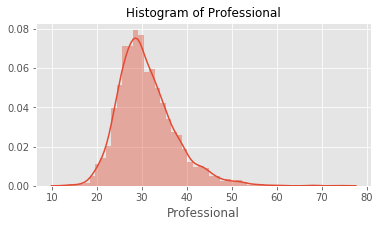

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


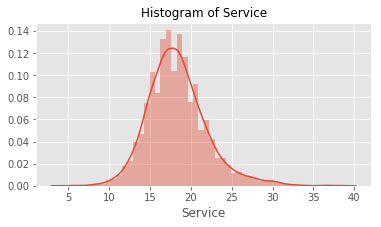

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


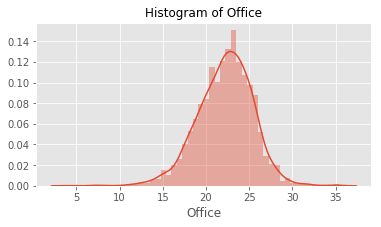

In [14]:
for a in ['Professional', 'Service', 'Office']:
    ax=plt.subplots(figsize=(6,3))
    ax=sns.distplot(counties[a])
    title="Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()
                             

## Feature engineering

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler=MinMaxScaler()
counties_scaled=pd.DataFrame(scaler.fit_transform(counties))

# get the columns from initial data-frame
counties_scaled.columns = counties.columns

# get the index from the initial data-frame
counties_scaled.index=counties.index
counties_scaled.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,0.361050,0.100593,0.319748,0.063816,0.183121,0.227941,0.325620,0.361446,0.642173,0.178756,0.307554,0.920582,0.294314,0.001621,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,0.351957,0.047095,0.358980,0.039464,0.191083,0.235294,0.323967,0.382530,0.734824,0.235751,0.201439,0.889262,0.294314,0.001621,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,0.198886,0.128195,0.183283,0.045206,0.402866,0.555147,0.219835,0.334337,0.607029,0.235751,0.415468,0.879195,0.364548,0.006483,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,0.249473,0.176666,0.210191,0.099320,0.245223,0.341912,0.132231,0.388554,0.437700,0.448187,0.426259,0.872483,0.451505,0.008104,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,0.312641,0.136163,0.245370,0.039266,0.243631,0.333333,0.247934,0.274096,0.632588,0.305699,0.357914,0.891499,0.374582,0.006483,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


In [17]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,0.315390,0.122277,0.303006,0.082209,0.256217,0.296425,0.289143,0.401913,0.578683,0.285468,0.282946,0.827745,0.343789,0.015761,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,0.114280,0.090832,0.103700,0.068549,0.132451,0.143289,0.105267,0.109489,0.102100,0.109156,0.103197,0.085178,0.097269,0.049593,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,0.245164,0.064738,0.240406,0.042368,0.170382,0.199755,0.218182,0.331325,0.514377,0.209845,0.206835,0.799776,0.280936,0.001621,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,0.303216,0.101304,0.294356,0.064872,0.234873,0.278186,0.271074,0.394578,0.584665,0.270725,0.273381,0.844519,0.331104,0.006483,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,0.367937,0.150545,0.354526,0.100178,0.307325,0.367647,0.345455,0.460843,0.648562,0.341969,0.348471,0.878076,0.394649,0.012966,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 3: Data Modeling

### Dimension reduction

In [18]:
counties_scaled.shape

(3218, 34)

In [19]:
role

'arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200201T085431'

In [20]:
bucket='md-ml-labs-bucket'
from sagemaker import PCA
num_components=33

In [21]:
# instantiate a principal component analysis sagemaker object
pca_SM = PCA(
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    output_path='s3://' + bucket + '/counties/',
    num_components=num_components)

In [22]:
# convert all values explicitly to float32
train_data = counties_scaled.values.astype('float32')

In [23]:
%%time

# launch the pca job in sagemaker
pca_SM.fit(pca_SM.record_set(train_data))

2020-02-01 17:43:51 Starting - Starting the training job...
2020-02-01 17:43:52 Starting - Launching requested ML instances...
2020-02-01 17:44:48 Starting - Preparing the instances for training.........
2020-02-01 17:46:08 Downloading - Downloading input data...
2020-02-01 17:46:48 Training - Training image download completed. Training in progress.
2020-02-01 17:46:48 Uploading - Uploading generated training model
2020-02-01 17:46:48 Completed - Training job completed
Docker entrypoint called with argument(s): train
[02/01/2020 17:46:39 INFO 139876347213632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[02/01/2020 17:46:39 INFO 139876347213632] Reading provided configuration from /opt/ml/inpu

In [24]:
job_name = 'pca-2020-02-01-17-43-51-344'
model_key = "counties/" + job_name + "/output/model.tar.gz"

In [25]:
# download model results
boto3.resource('s3').Bucket(bucket).download_file(model_key, './data/model.tar.gz')

In [26]:
# un-tar to the same folder
os.system('tar -zxvf ./data/model.tar.gz -C ./data/')

0

In [27]:
# # this is unnecessary
# os.system('unzip -d ./data/ ./data/model_algo-1')

2304

In [28]:
import mxnet as mx

In [29]:

# load model parameters, that is the output of the pca job
pca_model_params = mx.ndarray.load('./data/model_algo-1')

In [32]:
s = pd.DataFrame(pca_model_params['s'].asnumpy())
v = pd.DataFrame(pca_model_params['v'].asnumpy())

In [38]:
print(s.shape)
print(s)

(33, 1)
            0
0    0.017896
1    0.030864
2    0.032131
3    0.035486
4    0.094832
5    0.126994
6    0.402887
7    1.408476
8    1.510049
9    1.595794
..        ...
23   5.018966
24   5.578647
25   5.980970
26   6.392514
27   7.695221
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180

[33 rows x 1 columns]


In [40]:
print(v.shape)

(34, 33)


In [41]:
v

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.002469,0.025647,0.002508,0.001504,-0.323074,-0.178807,-0.001509,0.032337,0.034215,0.000954,0.025160,-0.080561,-0.033845,-0.002342,0.103417,0.016504,0.189065,-0.259911,-0.057888,0.213961,-0.054363,-0.033644,-0.014749,0.017474,-0.059638,0.086932,-0.011967,0.010309,-0.016843,0.009003,-0.076393,0.015988,0.005046
1,-0.028060,-0.686634,-0.019628,-0.041537,-0.331368,-0.241622,-0.001658,0.031944,0.032659,0.002615,0.025439,-0.084339,-0.034967,-0.003055,0.103212,0.014019,0.187424,-0.260257,-0.057569,0.212943,-0.054832,-0.033499,-0.014217,0.017304,-0.059000,0.086065,-0.012463,0.010201,-0.016702,0.008634,-0.075959,0.015730,0.004953
2,0.032577,0.717301,0.024073,0.045103,-0.315083,-0.117787,-0.001385,0.032718,0.035725,-0.000658,0.024889,-0.076892,-0.032755,-0.001650,0.103616,0.018916,0.190660,-0.259576,-0.058198,0.214949,-0.053908,-0.033784,-0.015267,0.017640,-0.060259,0.087775,-0.011484,0.010413,-0.016979,0.009362,-0.076814,0.016238,0.005136
3,0.000218,-0.000916,-0.000623,-0.000381,-0.001569,0.010348,-0.495563,-0.001460,0.005473,-0.037492,-0.010842,-0.028988,-0.018689,0.029860,0.117478,0.045739,0.058163,0.117688,-0.146132,-0.024688,0.064296,0.081790,0.132818,0.082821,-0.059665,-0.106154,0.107721,-0.047817,0.102068,-0.534674,-0.322117,-0.278090,0.392619
4,0.000242,-0.000709,-0.000601,-0.000256,-0.002276,0.010803,-0.501500,0.043600,-0.009186,0.032023,0.016430,-0.030659,-0.041825,0.035092,0.145839,0.034944,-0.016364,0.036871,-0.172959,0.059563,0.163684,-0.107469,0.079269,0.025476,-0.103535,-0.048642,0.059254,0.203843,-0.210340,-0.160298,0.373134,0.092912,-0.601972
5,0.000239,-0.001190,-0.000525,-0.000278,-0.001989,0.008303,-0.429078,0.026844,0.018039,0.027393,0.037434,-0.030760,-0.036497,0.041218,0.073949,0.043953,0.021681,0.113003,-0.136452,-0.012214,-0.051560,0.000969,0.078262,-0.021767,-0.174813,-0.101013,0.204929,-0.174230,0.307641,0.622484,-0.001154,0.348801,0.207530
6,0.000293,-0.001541,-0.000554,-0.000270,-0.002853,0.010491,-0.494917,-0.032905,0.009097,0.005804,0.043293,0.089783,0.076793,-0.011081,-0.120542,0.128855,0.236661,-0.134671,0.451923,-0.190989,-0.192915,0.036789,-0.278598,-0.126655,0.336893,0.163820,-0.263071,0.000560,-0.136468,0.124463,0.038152,-0.113913,0.038430
7,-0.000056,0.002450,-0.000145,-0.000281,-0.006529,0.008688,-0.236822,-0.298687,-0.384994,0.122059,-0.002856,0.012042,0.027093,-0.131324,-0.322135,-0.381228,-0.452699,-0.194135,-0.043752,0.294576,0.043190,-0.012703,-0.015152,0.098355,-0.027404,0.177549,-0.118251,-0.014261,-0.026953,0.059567,-0.173816,-0.002377,-0.004536
8,0.000447,-0.000107,-0.000509,0.000475,0.003596,-0.002848,-0.130125,0.445075,0.634196,-0.273251,-0.238406,-0.052940,0.000166,-0.126986,-0.216207,-0.299919,-0.270333,-0.079905,0.019217,0.089072,-0.021264,0.017810,-0.029434,-0.004493,-0.012551,0.023354,-0.068123,-0.012148,-0.003319,0.011659,-0.018965,-0.014045,0.001652
9,-0.004114,-0.078060,-0.002045,-0.012714,0.146230,0.870448,0.018119,0.022948,0.045393,-0.007733,0.023484,-0.082769,-0.033566,-0.003272,0.107595,0.018106,0.197639,-0.270189,-0.062247,0.221115,-0.056315,-0.039186,-0.015279,0.017918,-0.064002,0.092885,-0.011510,0.011406,-0.022275,0.011346,-0.084550,0.019234,0.004569


In [53]:
n_comp=6
s.iloc[-n_comp:,:]

,0
27,7.695221
28,7.991313
29,10.180052
30,11.718245
31,13.035975
32,19.592180


In [54]:
s.iloc[-n_comp:,:].apply(lambda x: x*x).sum()

0    917.81842
dtype: float32

In [55]:
s.apply(lambda x: x*x).sum()

0    1195.853271
dtype: float32

In [56]:
# this number explain how much variance of the total variance, is explained by the last n_comp components
s.iloc[-n_comp:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.767501
dtype: float32

In [59]:
# we'll take n_comp components from our components matrix
s_5 = s.iloc[-5:, :]
s_5

,0
28,7.991313
29,10.180052
30,11.718245
31,13.035975
32,19.592180


In [60]:
v_5 = v.iloc[:, -5:]
v_5.columns = [0, 1, 2, 3, 4]
v_5

,0,1,2,3,4
0,-0.016843,0.009003,-0.076393,0.015988,0.005046
1,-0.016702,0.008634,-0.075959,0.015730,0.004953
2,-0.016979,0.009362,-0.076814,0.016238,0.005136
3,0.102068,-0.534674,-0.322117,-0.278090,0.392619
4,-0.210340,-0.160298,0.373134,0.092912,-0.601972
5,0.307641,0.622484,-0.001154,0.348801,0.207530
6,-0.136468,0.124463,0.038152,-0.113913,0.038430
7,-0.026953,0.059567,-0.173816,-0.002377,-0.004536
8,-0.003319,0.011659,-0.018965,-0.014045,0.001652
9,-0.022275,0.011346,-0.084550,0.019234,0.004569


In [62]:
# show the first component that 
comp_num = 1
first_comp = v_5[5 - comp_num]
print(first_comp)

0     0.005046
1     0.004953
2     0.005136
3     0.392619
4    -0.601972
5     0.207530
6     0.038430
7    -0.004536
8     0.001652
9     0.004569
        ...   
24   -0.004034
25    0.013728
26   -0.078116
27    0.054965
28    0.003422
29   -0.103600
30    0.141610
31   -0.063451
32   -0.014286
33    0.233627
Name: 4, Length: 34, dtype: float32


In [64]:
list(zip(first_comp, counties_scaled.columns))

[(0.005045896861702204, 'TotalPop'),
 (0.004953121300786734, 'Men'),
 (0.005135972984135151, 'Women'),
 (0.39261946082115173, 'Hispanic'),
 (-0.6019721031188965, 'White'),
 (0.20752954483032227, 'Black'),
 (0.03843024745583534, 'Native'),
 (-0.0045360904186964035, 'Asian'),
 (0.001652127131819725, 'Pacific'),
 (0.004568854812532663, 'Citizen'),
 (-0.19768287241458893, 'Income'),
 (-0.0318128876388073, 'IncomeErr'),
 (-0.1962733119726181, 'IncomePerCap'),
 (-0.027648651972413063, 'IncomePerCapErr'),
 (0.3309999108314514, 'Poverty'),
 (0.34302011132240295, 'ChildPoverty'),
 (-0.09724240750074387, 'Professional'),
 (0.14444157481193542, 'Service'),
 (0.029167257249355316, 'Office'),
 (0.015059510245919228, 'Construction'),
 (-0.007182629778981209, 'Production'),
 (0.011044306680560112, 'Drive'),
 (0.0406070351600647, 'Carpool'),
 (0.007401055656373501, 'Transit'),
 (-0.004033944569528103, 'Walk'),
 (0.013727928511798382, 'OtherTransp'),
 (-0.07811573147773743, 'WorkAtHome'),
 (0.054965075

In [67]:
comps = pd.DataFrame(list(zip(first_comp, counties_scaled.columns)), columns=['weights', 'features'])
comps

,weights,features
0,0.005046,TotalPop
1,0.004953,Men
2,0.005136,Women
3,0.392619,Hispanic
4,-0.601972,White
5,0.207530,Black
6,0.038430,Native
7,-0.004536,Asian
8,0.001652,Pacific
9,0.004569,Citizen


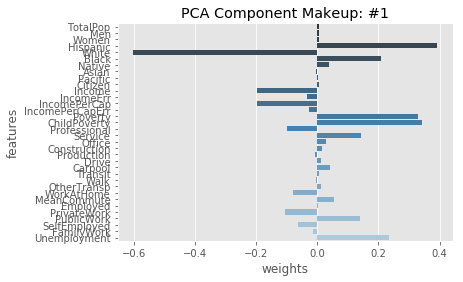

In [75]:
ax = sns.barplot(
#     data=comps.sort_values('abs_weights', ascending=False).head(10), 
    data=comps,
    x="weights", 
    y="features", 
    palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(comp_num))
plt.show()

In [76]:
PCA_list=['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5']

### Deploy

In [77]:
%%time

# deploy
pca_predictor = pca_SM.deploy(
    initial_instance_count=1, 
    instance_type='ml.t2.medium')

---------------!CPU times: user 252 ms, sys: 11.5 ms, total: 263 ms
Wall time: 7min 32s


In [78]:
%%time

# predict
# apply original data to the pca predictor
result = pca_predictor.predict(train_data)

CPU times: user 207 ms, sys: 12.1 ms, total: 219 ms
Wall time: 552 ms


In [83]:
counties_transformed=pd.DataFrame()

a1 = result[0]

In [ ]:
a1

In [84]:
# loop over the result of the prediction and append each element to counties_transformed
for a in result:
    b=a.label['projection'].float32_tensor.values
    counties_transformed=counties_transformed.append([list(b)])

# get the index and columns from countries_scaled data-frame
# but keep the last 5 columns
counties_transformed.index=counties_scaled.index
counties_transformed=counties_transformed.iloc[:,-5:]
counties_transformed.columns=PCA_list

In [85]:
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030


### Use the transformed result with last 5 components to clasify counties using k-means

In [86]:
from sagemaker import KMeans

In [87]:
num_clusters = 7

# instantiate a KMeans object
kmeans = KMeans(
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    output_path='s3://'+ bucket +'/counties/',              
    k=num_clusters)

In [88]:
# we replace the train_data with the results of pca reduction
train_data = counties_transformed.values.astype('float32')

In [90]:
%%time

# run the KMeans clusterization 
kmeans.fit(kmeans.record_set(train_data))

2020-02-01 19:17:27 Starting - Starting the training job...
2020-02-01 19:17:29 Starting - Launching requested ML instances......
2020-02-01 19:18:53 Starting - Preparing the instances for training.........
2020-02-01 19:20:21 Downloading - Downloading input data...
2020-02-01 19:20:57 Training - Training image download completed. Training in progress.
2020-02-01 19:20:57 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
[02/01/2020 19:20:54 INFO 140408472364864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': 

In [91]:
%%time

# deploy he nodel
kmeans_predictor = kmeans.deploy(
    initial_instance_count=1, 
    instance_type='ml.t2.medium')

---------------!CPU times: user 247 ms, sys: 12.8 ms, total: 260 ms
Wall time: 7min 31s


In [92]:
%%time

# predict on training data
result=kmeans_predictor.predict(train_data)

CPU times: user 218 ms, sys: 94 µs, total: 218 ms
Wall time: 485 ms


In [96]:
# lets see how results looks like
a1 = result[0]
type(a1)

record_pb2.Record

In [97]:
a1

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 4.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.2822551131248474
    }
  }
}

In [100]:
# create an array out of the results
# this identify the closest cluster out of the 7 clusters that we run the fit for
# each county get a label
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
cluster_labels[:10]


[4.0, 4.0, 2.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 4.0]

In [104]:
# this counts the values ver each cluster out of the seven
# means how many counties belong to each cluster, by the distance to centroid 
pd.DataFrame(cluster_labels)[0].value_counts()

4.0    1358
6.0     518
0.0     467
2.0     378
1.0     358
3.0     107
5.0      32
Name: 0, dtype: int64

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


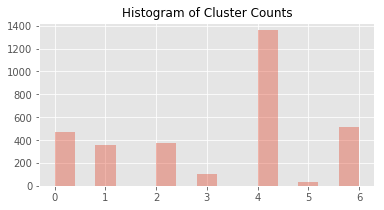

In [105]:
ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(cluster_labels, kde=False)

title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

## Step 4: Conclusions

### Access the KMeans model attributes

In [106]:
job_name = 'kmeans-2020-02-01-19-17-27-635'
model_key = "counties/" + job_name + "/output/model.tar.gz"

# dowload the artifacts from s3 localy under "data-kmeans" folder
boto3.resource('s3').Bucket(bucket).download_file(model_key, './data-kmeans/model.tar.gz')
os.system('tar -zxvf ./data-kmeans/model.tar.gz -C ./data-kmeans/')

In [107]:
os.system('unzip -d ./data-kmeans/ ./data-kmeans/model_algo-1 ')

2304

In [109]:
# load model attributes using mxnet
Kmeans_model_params = mx.ndarray.load('./data-kmeans/model_algo-1')

In [110]:
# model parameters contains coordinates of the centroids in out 5 dimension space
# as an ndarray
Kmeans_model_params

[
 [[-0.02354583  0.07371874 -0.34453073  0.04793901 -0.1608972 ]
  [ 0.05948725 -0.05939928 -0.02307737 -0.09609918  0.21640223]
  [ 0.0946615   0.26737744  0.07597196  0.23631473  0.37596908]
  [-0.08824383 -0.39184558 -0.1697881  -0.276773    1.224046  ]
  [-0.04206858 -0.07860726  0.0859607   0.10128559 -0.13210894]
  [-0.37644348  0.54276454  0.20176822 -0.705885    0.6696289 ]
  [ 0.042047    0.04849273  0.0613776  -0.29930723 -0.22871406]]
 <NDArray 7x5 @cpu(0)>]

In [111]:
Kmeans_model_params[0]


[[-0.02354583  0.07371874 -0.34453073  0.04793901 -0.1608972 ]
 [ 0.05948725 -0.05939928 -0.02307737 -0.09609918  0.21640223]
 [ 0.0946615   0.26737744  0.07597196  0.23631473  0.37596908]
 [-0.08824383 -0.39184558 -0.1697881  -0.276773    1.224046  ]
 [-0.04206858 -0.07860726  0.0859607   0.10128559 -0.13210894]
 [-0.37644348  0.54276454  0.20176822 -0.705885    0.6696289 ]
 [ 0.042047    0.04849273  0.0613776  -0.29930723 -0.22871406]]
<NDArray 7x5 @cpu(0)>

In [112]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns

In [113]:
cluster_centroids

,comp_1,comp_2,comp_3,comp_4,comp_5
0,-0.023546,0.073719,-0.344531,0.047939,-0.160897
1,0.059487,-0.059399,-0.023077,-0.096099,0.216402
2,0.094661,0.267377,0.075972,0.236315,0.375969
3,-0.088244,-0.391846,-0.169788,-0.276773,1.224046
4,-0.042069,-0.078607,0.085961,0.101286,-0.132109
5,-0.376443,0.542765,0.201768,-0.705885,0.669629
6,0.042047,0.048493,0.061378,-0.299307,-0.228714


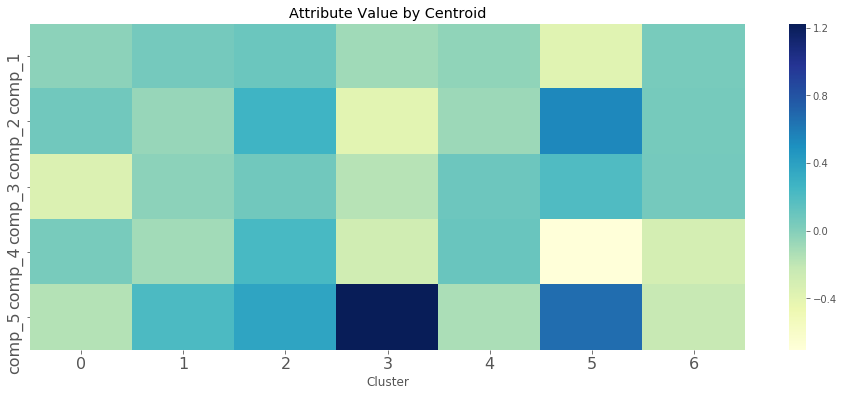

In [114]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [116]:
list(map(int, cluster_labels))[:10]

[4, 4, 2, 4, 4, 2, 2, 4, 2, 4]

In [117]:
# add a new column with labels representing the cluster they belong to
counties_transformed['labels']=list(map(int, cluster_labels))
counties_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
Alabama-Autauga,-0.010824,0.120480,-0.088356,0.160527,-0.060274,4
Alabama-Baldwin,-0.068677,-0.023092,-0.145743,0.185969,-0.149684,4
Alabama-Barbour,0.093111,0.297829,0.146258,0.296662,0.506202,2
Alabama-Bibb,0.283526,0.011757,0.224402,0.190861,0.069224,4
Alabama-Blount,0.100738,-0.193824,0.022714,0.254403,-0.091030,4


## Cleanup

In [118]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

In [119]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)